In [55]:
%reset

# 1. Imports

In [1]:
import mne
import time

import custom_modules.file_handling as  fh
import custom_modules.classification_ptu as clas
import custom_modules.preprocessing_ptu as prep

import importlib
importlib.reload(clas)
importlib.reload(fh)
importlib.reload(prep)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Constants

In [20]:
data_path = 'D:/Diplomarbeit_data/eeg/'
# subjects = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07' , 'A08', 'A10']
subjects = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07' , 'A08', 'A09', 'A10']
trial_type_markers = ['LTR-s', 'LTR-l','RTL-s', 'RTL-l', 'TTB-s', 'TTB-l', 'BTT-s', 'BTT-l']

mne.set_log_level('WARNING') #'INFO' 'WARNING'

In [21]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_03_22_glm_results_cue_aligned', dst_fldr='2023_03_22_glm_results_cue_aligned')

In [22]:
# Load glm:
# Load bootstrapping matrices:
src = src_path
means = np.load(f'{src}/regr_coeff_global_means.npy')    # .npy extension is added if not given
lowers = np.load(f'{src}/regr_coeff_global_lowers.npy')
uppers = np.load(f'{src}/regr_coeff_global_uppers.npy')

# Save t-test matrices:
stat = np.load(f'{src}/regr_coeff_stats.npy')
p_val = np.load(f'{src}/regr_coeff_pval.npy')

In [23]:
# Load one epochs file:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_03_22_epoched_cue_aligned', dst_fldr='2023_03_22_glm_results_cue_aligned')
epochs = prep.vis_epochs_for_sbj(src_path, 'A01')

In [24]:
n_chan, n_times = p_val.shape
p_val = p_val
p_extended = p_val.reshape((1,n_chan,n_times))

In [25]:
p_epochs = mne.EpochsArray(p_extended, epochs.info)

C:\Users\peter\AppData\Local\Temp\ipykernel_23424\800924819.py:2: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  fig = p_epochs.average().plot_topomap(times, ch_type='eeg',ncols=7, nrows='auto',scalings=dict(eeg=1), units='a.u.',vlim=(0,1))


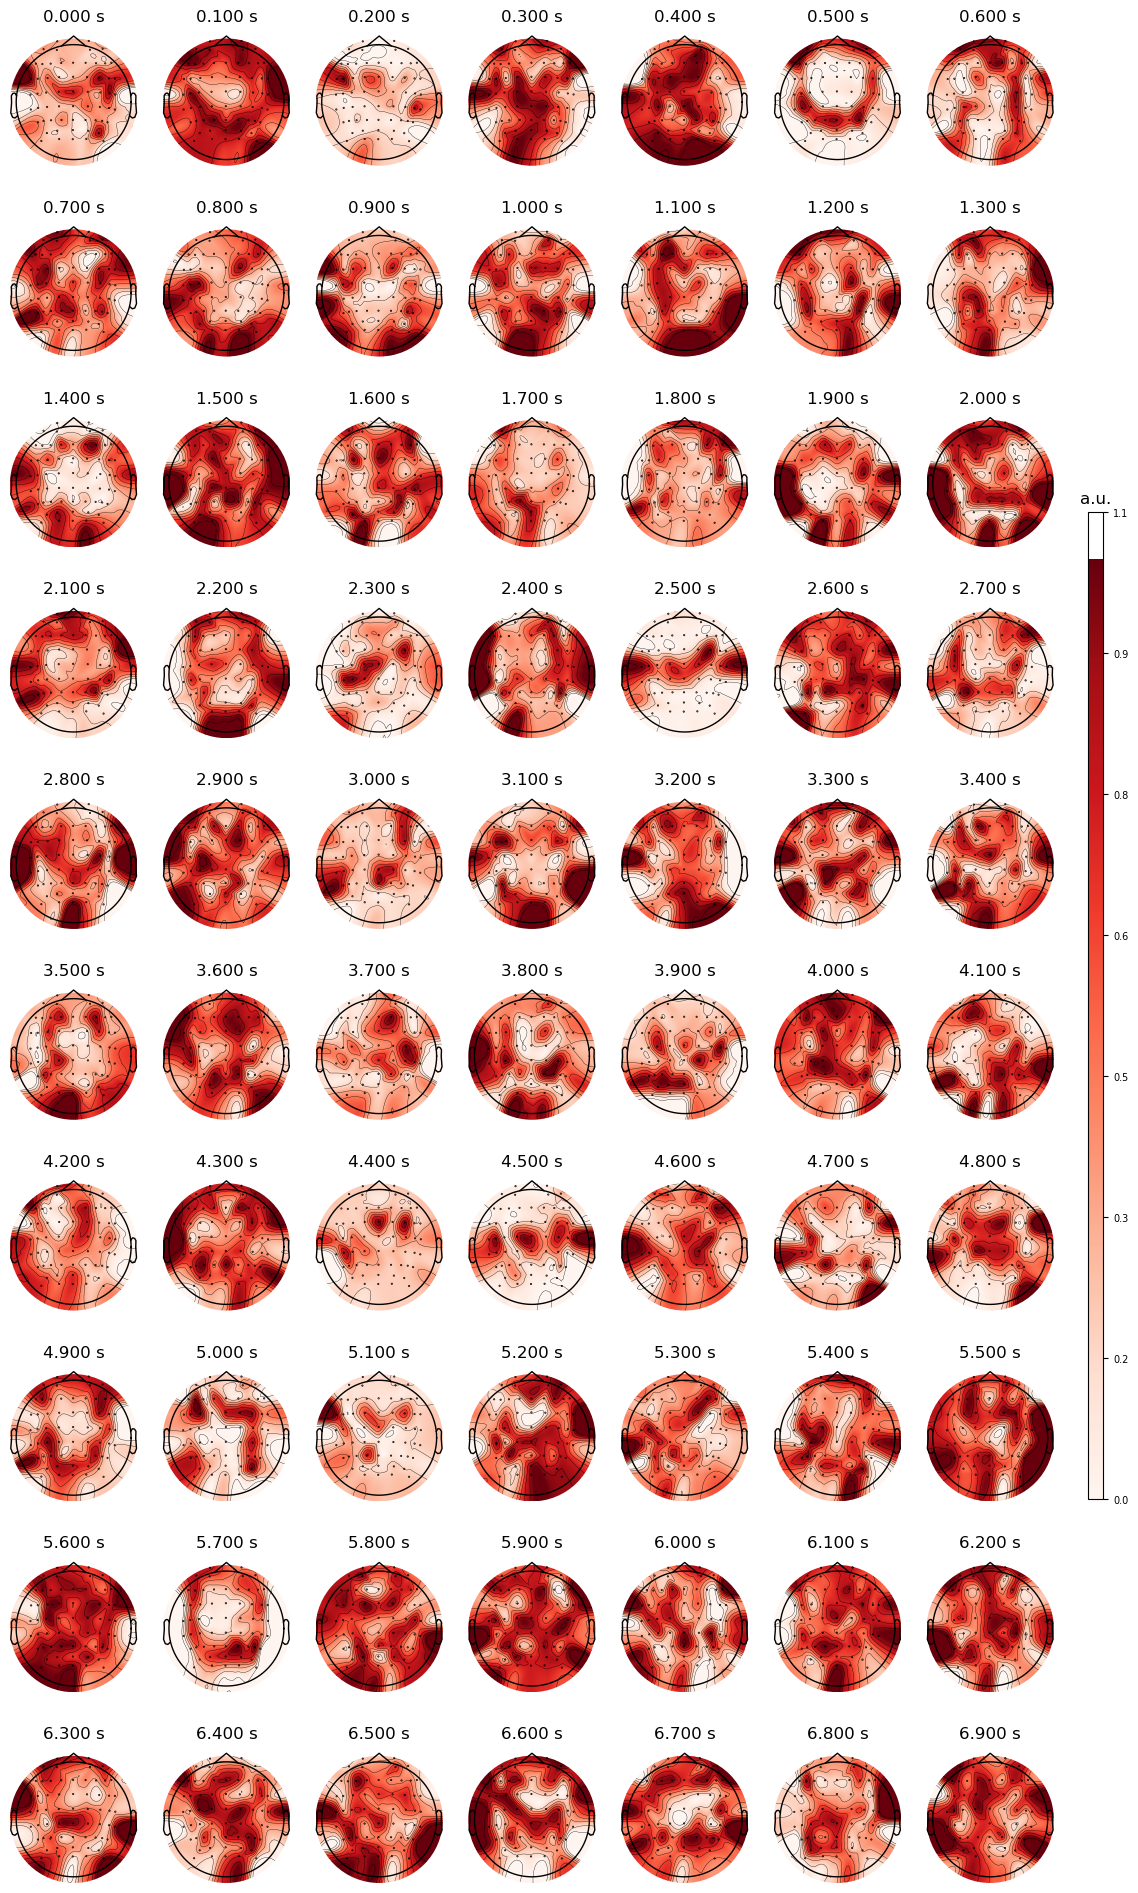

In [60]:
times = np.arange(0.0, 7.0, 0.1)
fig = p_epochs.average().plot_topomap(times, ch_type='eeg',ncols=7, nrows='auto',scalings=dict(eeg=1), units='a.u.',vlim=(0,1))
# fig.savefig(f'{dst}/topomaps_{title_alignment}_{cond}_{title_cond}.png', dpi=400)

In [62]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_03_22_glm_results_movement_aligned',
                                  dst_fldr='2023_03_22_glm_results_movement_aligned')
# Load glm:
# Load bootstrapping matrices:
src = src_path
means = np.load(f'{src}/regr_coeff_global_means.npy')  # .npy extension is added if not given
lowers = np.load(f'{src}/regr_coeff_global_lowers.npy')
uppers = np.load(f'{src}/regr_coeff_global_uppers.npy')

# Save t-test matrices:
stat = np.load(f'{src}/regr_coeff_stats.npy')
p_val = np.load(f'{src}/regr_coeff_pval.npy')
# Load one epochs file:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_03_22_epoched_movement_aligned',
                                  dst_fldr='2023_03_22_glm_results_movement_aligned')
epochs = prep.vis_epochs_for_sbj(src_path, 'A01')

n_chan, n_times = p_val.shape
p_val = p_val
p_extended = p_val.reshape((1, n_chan, n_times))
p_epochs = mne.EpochsArray(p_extended, epochs.info, tmin=epochs.tmin)
times = np.arange(-2.5, 3.5, 0.1)
fig = p_epochs.average().plot_topomap(times, ch_type='eeg', ncols=7, nrows='auto', scalings=dict(eeg=1), units='a.u.', vlim=(0, 1))
# fig.savefig(f'{dst}/topomaps_{title_alignment}_{cond}_{title_cond}.png', dpi=400)

C:\Users\peter\AppData\Local\Temp\ipykernel_23424\574816392.py:25: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  fig = p_epochs.average().plot_topomap(times, ch_type='eeg', ncols=7, nrows='auto', scalings=dict(eeg=1), units='a.u.', vlim=(0, 1))


# 4. Single channel classification

In [27]:
df = pd.read_csv('dataframes/classification/classification_single_channel_df.csv', index_col=0) # Load dataframe

Calc mean accuracy for each timepoint and for each channel (channel is n_timeopints)

In [30]:
cols = ['Timepoint', 'Mean_accuracy', 'Type', 'N_timepoints']#, 'Upper', 'Lower']
confidence = .95
df_mean = pd.DataFrame(columns=cols)
for n_timepoints in df['N_timepoints'].unique():
    print(f'{n_timepoints}')
    timepoints = df[(df['N_timepoints']==n_timepoints)]['Timepoint'].unique()
    for tp in timepoints:
        # Get average overall subjects for each timepoint:
        accs = np.array(df[(df['N_timepoints'] == n_timepoints) & (df['Timepoint'] == tp)]['Accuracy'])
        mean = accs.mean()

        # Bootstrapping for confidence interval:
        # values = [np.random.choice(accs,size=len(accs),replace=True).mean() for i in range(1000)]
        # lower, upper = np.percentile(values,[100*(1-confidence)/2,100*(1-(1-confidence)/2)])

        df_mean.loc[len(df_mean)] = [tp, mean, type, n_timepoints] #, upper, lower]

df_mean = df_mean.dropna()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


Load example epochs for epochs.info and channel dimensions

In [34]:
# Load one epochs file:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_03_22_epoched_cue_aligned', dst_fldr='2023_03_22_glm_results_cue_aligned')
epochs = prep.vis_epochs_for_sbj(src_path, 'A01')

ch_names = epochs.ch_names
n_chans = len(ch_names)

Create an n_channels x n_timepoints matrix out of the mean accuracies:

In [38]:
n_timepoints = len(df_mean.Timepoint.unique())
acc_matrix = np.zeros((n_chans,n_timepoints))

Fill the matrix

In [52]:
for chan in range(n_chans):
    for tp in range(n_timepoints):
        acc_matrix[chan,tp] = df_mean[(df_mean['N_timepoints'] == chan) & (df_mean['Timepoint']==tp/10)]['Mean_accuracy']
        # print(df_mean[(df_mean['N_timepoints'] == chan) & (df_mean['Timepoint']==tp/10)]['Mean_accuracy'])

acc_matrix = acc_matrix.reshape((1,n_chans,n_timepoints))

Put it into an epochs structure for the topoplot:

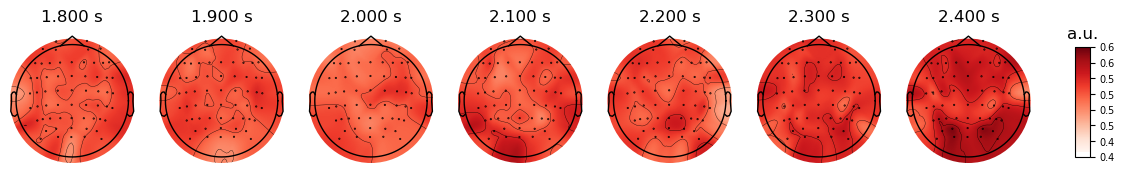

In [57]:
acc_epochs = mne.EpochsArray(acc_matrix, epochs.info)

times = [1.8,1.9,2.0,2.1,2.2,2.3,2.4]
fig = acc_epochs.average().plot_topomap(times, ch_type='eeg',ncols=7, nrows='auto',scalings=dict(eeg=1), units='a.u.',vlim=(0.4,0.6))
# fig.savefig(f'{dst}/topomaps_{title_alignment}_{cond}_{title_cond}.png', dpi=400)